In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load the data
df = pd.read_excel("C:\\Users\\Channabasava\\Desktop\\Test\\MMX_Task.xlsx", sheet_name='Sheet1')

## Exploratory Data Analysis

In [3]:
# Basic data info
print(f"Data shape: {df.shape}")
print("\nData types:\n", df.dtypes)
print("\nMissing values:\n", df.isnull().sum())

Data shape: (122, 20)

Data types:
 Department                            object
Week_Ending                   datetime64[ns]
Year                                  object
MAT                                   object
Sales                                float64
Discount1                            float64
Discount2                            float64
Holiday Dummy                          int64
Total SKU                            float64
Gasoline Price                       float64
Average Price                        float64
Email Clicks                         float64
Email Spends                         float64
Organic Search Impressions           float64
Modular Video Impressions            float64
Modular Video Spends                 float64
Paid Social Impressions              float64
Paid Social Spends                   float64
Paid Search Impressions              float64
Paid Search Spends                   float64
dtype: object

Missing values:
 Department                    0


In [4]:
# Convert Week_Ending to datetime
df['Week_Ending'] = pd.to_datetime(df['Week_Ending'])
df = df.sort_values('Week_Ending').reset_index(drop=True)

In [5]:
# Create time features for seasonality analysis
df['Week'] = df['Week_Ending'].dt.isocalendar().week
df['Month'] = df['Week_Ending'].dt.month
df['Quarter'] = df['Week_Ending'].dt.quarter
df['Year'] = df['Week_Ending'].dt.year

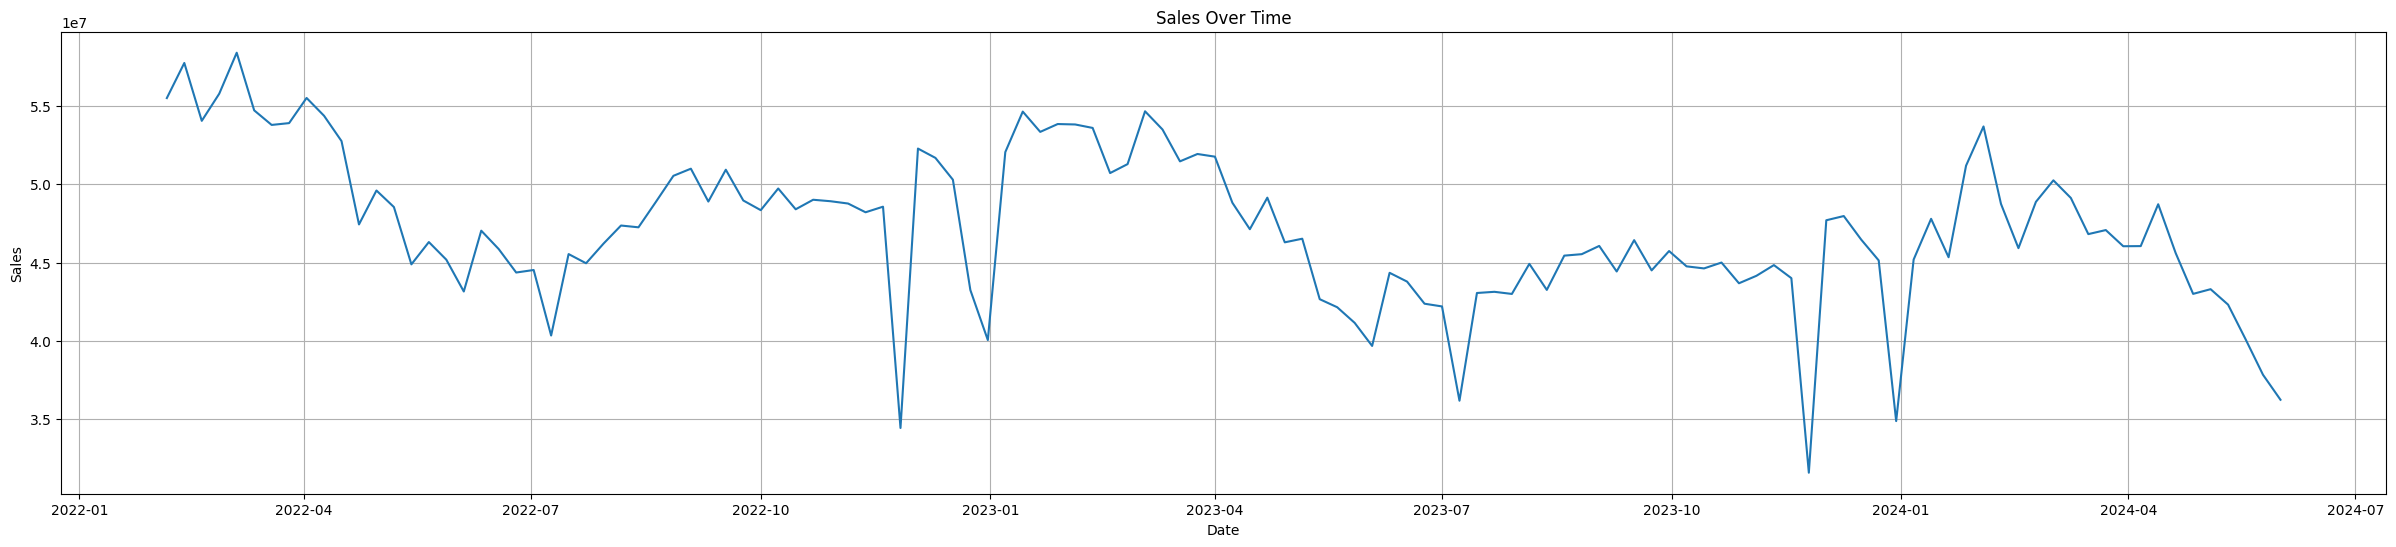

In [6]:
# Plot sales over time
plt.figure(figsize=(30, 6))
plt.plot(df['Week_Ending'], df['Sales'], label='Sales')
plt.title('Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.grid(True)
plt.show()

##Sales Trend: Sales show a generally stable trend with some cyclical patterns and a noticeable dip around holiday periods (especially end of year).
##Seasonality: Clear annual seasonality with peaks in Q1 and Q4, and troughs in summer months (June-August).

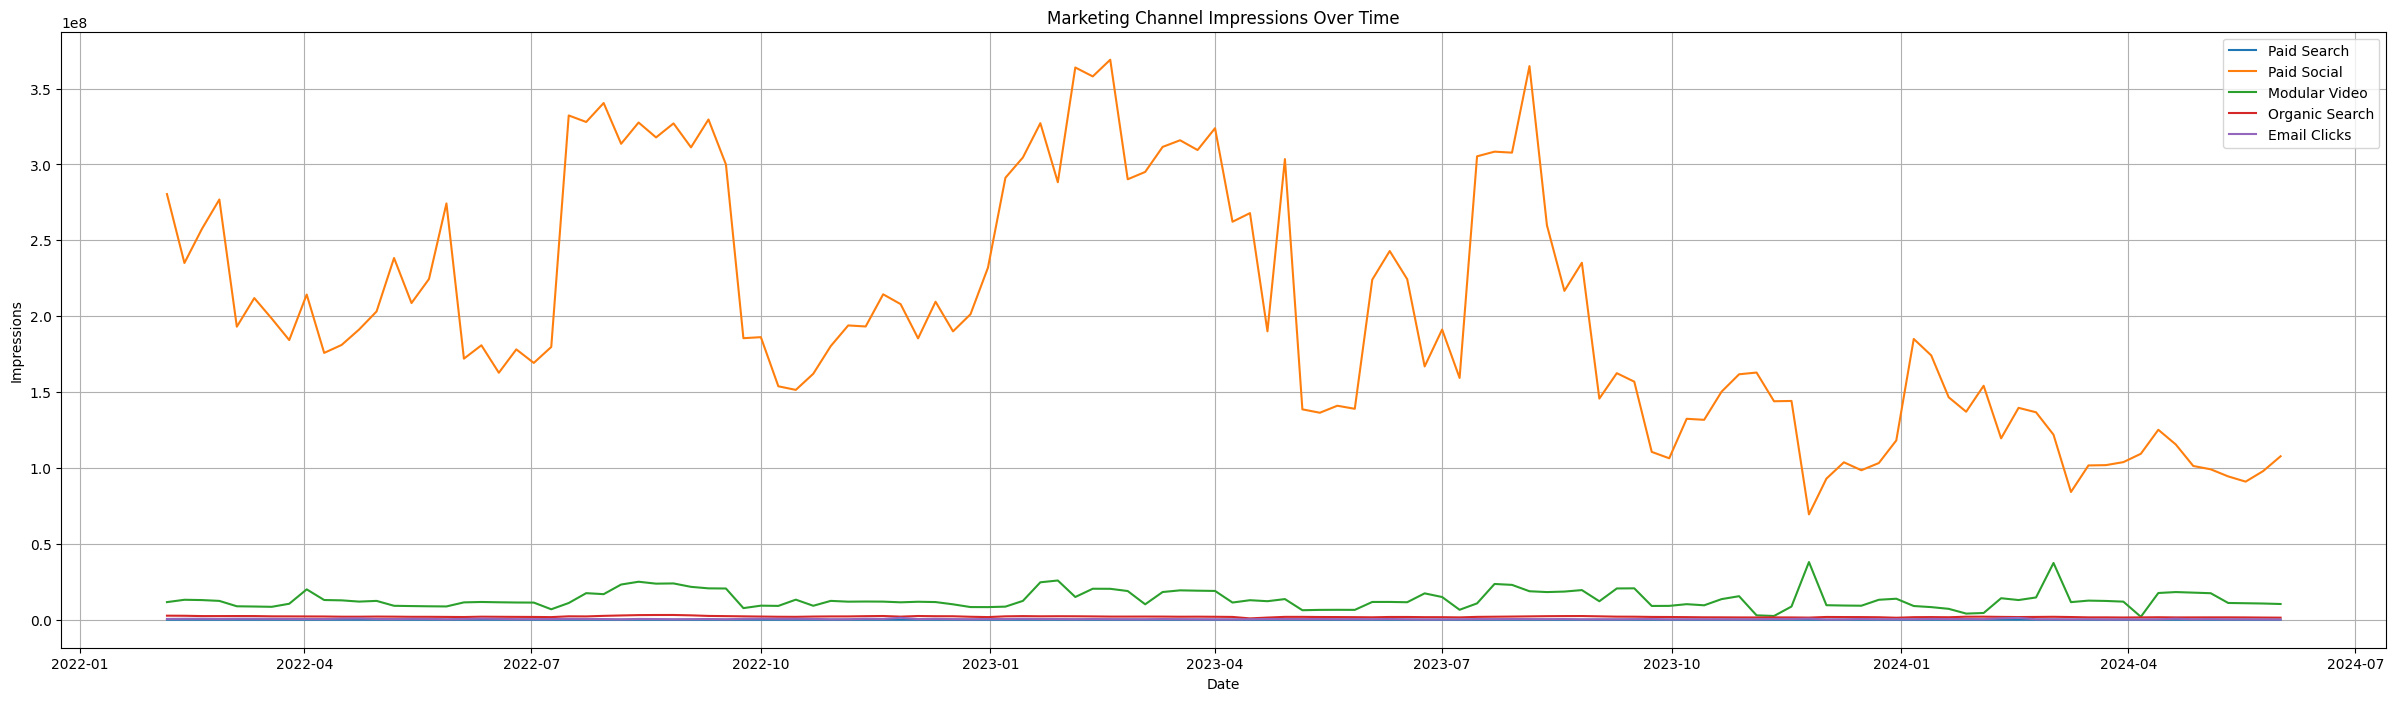

In [7]:
# Plot marketing impressions over time
plt.figure(figsize=(30, 8))
plt.plot(df['Week_Ending'], df['Paid Search Impressions'], label='Paid Search')
plt.plot(df['Week_Ending'], df['Paid Social Impressions'], label='Paid Social')
plt.plot(df['Week_Ending'], df['Modular Video Impressions'], label='Modular Video')
plt.plot(df['Week_Ending'], df['Organic Search Impressions'], label='Organic Search')
plt.plot(df['Week_Ending'], df['Email Clicks'], label='Email Clicks')
plt.title('Marketing Channel Impressions Over Time')
plt.xlabel('Date')
plt.ylabel('Impressions')
plt.legend()
plt.grid(True)
plt.show()

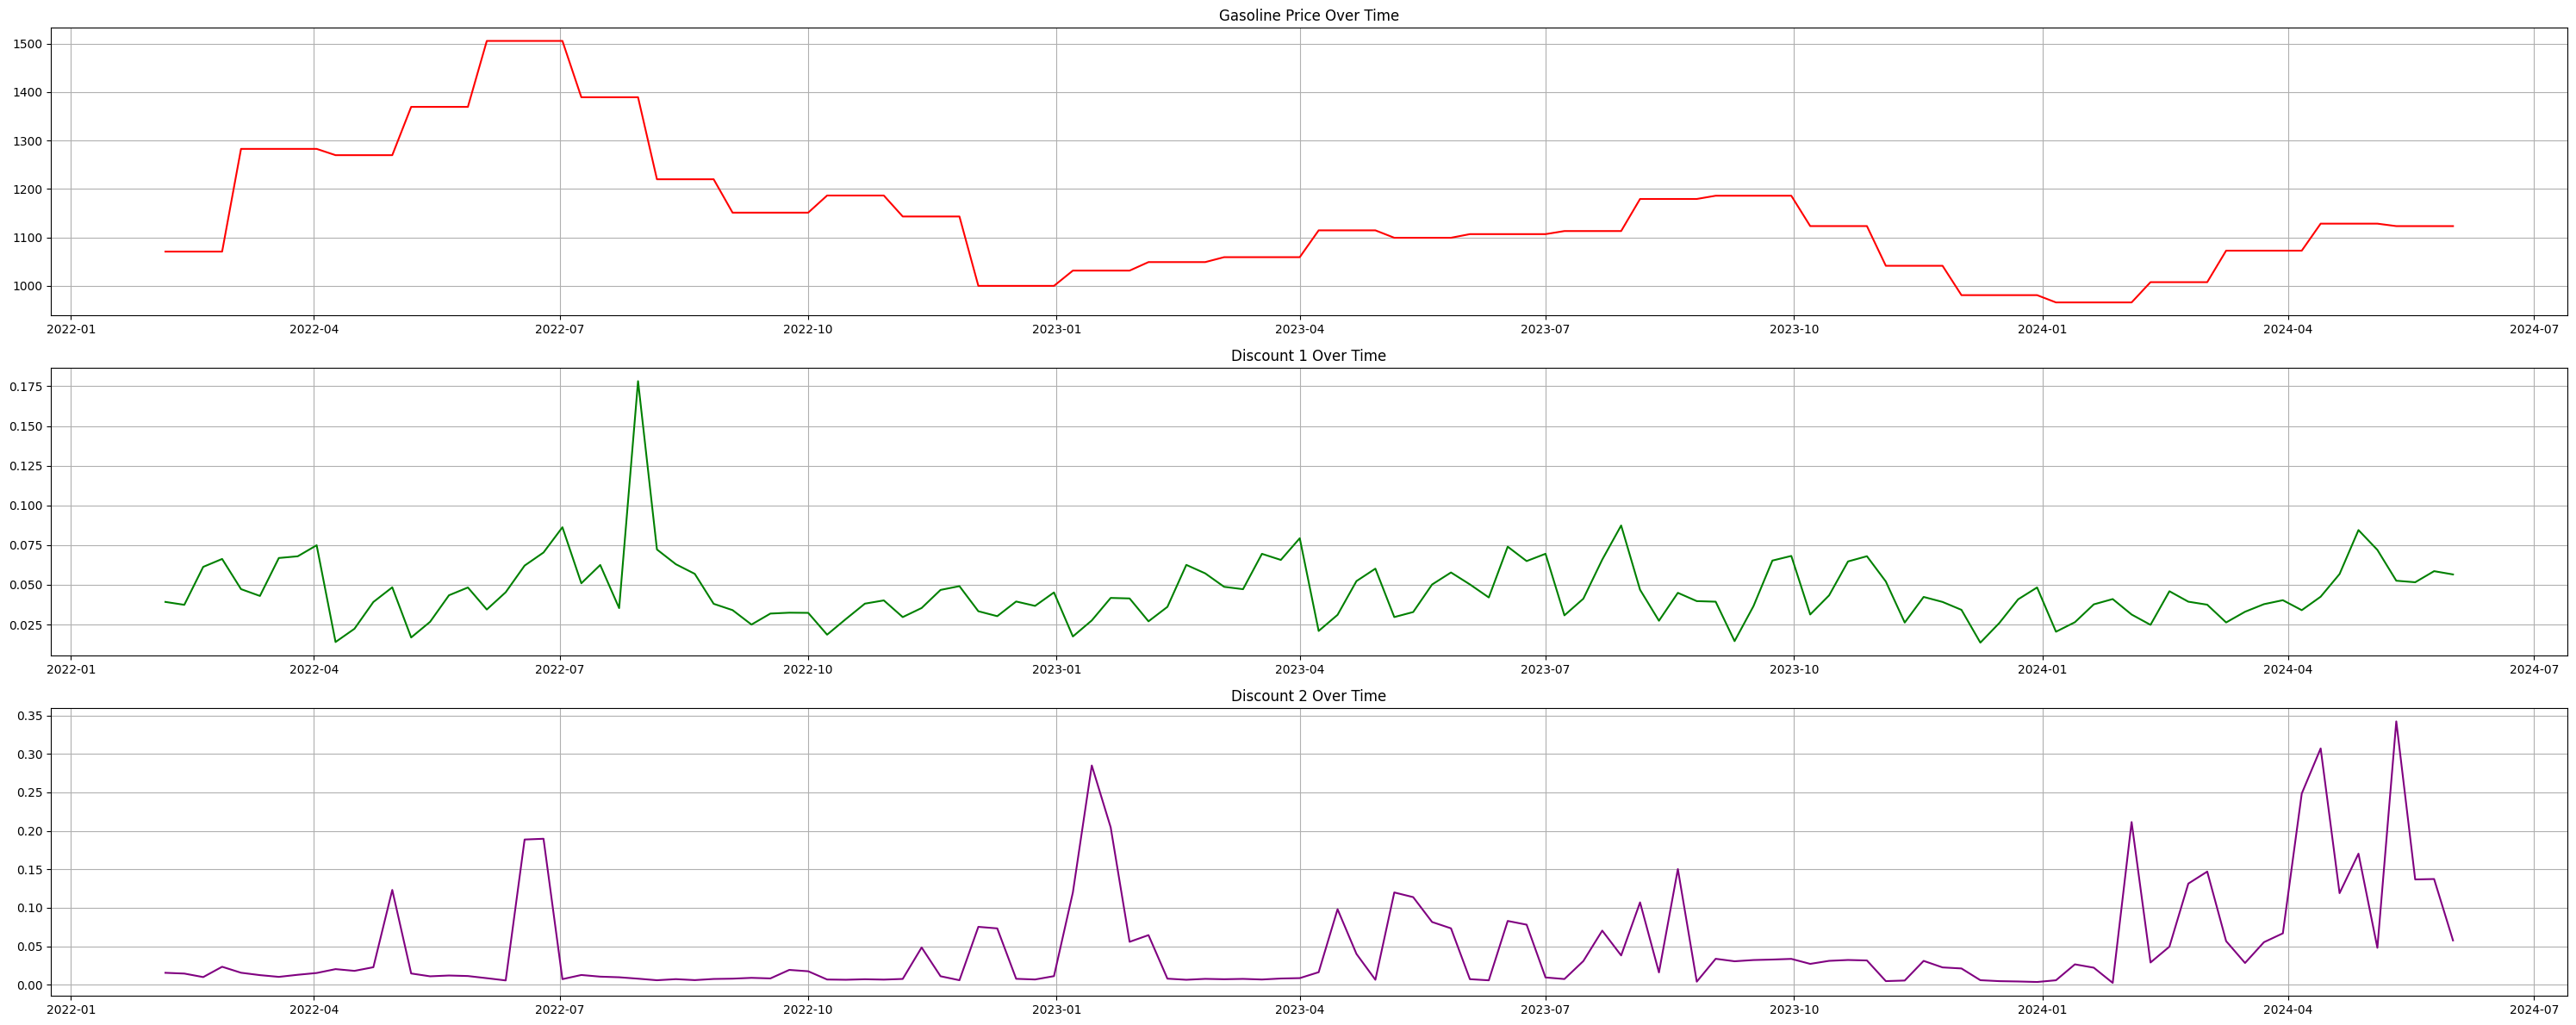

In [8]:
# Plot economic factors and promotions
fig, axes = plt.subplots(3, 1, figsize=(30, 12))
axes[0].plot(df['Week_Ending'], df['Gasoline Price'], color='red')
axes[0].set_title('Gasoline Price Over Time')
axes[0].grid(True)

axes[1].plot(df['Week_Ending'], df['Discount1'], color='green')
axes[1].set_title('Discount 1 Over Time')
axes[1].grid(True)

axes[2].plot(df['Week_Ending'], df['Discount2'], color='purple')
axes[2].set_title('Discount 2 Over Time')
axes[2].grid(True)

plt.tight_layout()
plt.show()

In [9]:
# Calculate correlations
corr_matrix = df[['Sales', 'Average Price', 'Paid Social Impressions', 
                 'Modular Video Impressions', 'Paid Search Impressions',
                 'Discount1', 'Discount2', 'Gasoline Price', 'Total SKU']].corr()

print("Exact Correlation Values:")
print(corr_matrix['Sales'].sort_values(ascending=False))

Exact Correlation Values:
Sales                        1.000000
Paid Search Impressions      0.546764
Paid Social Impressions      0.392407
Total SKU                    0.189031
Modular Video Impressions    0.058470
Discount2                   -0.031489
Gasoline Price              -0.050567
Discount1                   -0.131008
Average Price               -0.464362
Name: Sales, dtype: float64


1.Sales are negatively correlated with Average Price (-0.46) → Suggests price sensitivity.

2.Sales positively correlate with Paid Search (0.55), Organic Search (0.56), and Paid Social (0.39) → Indicates these marketing channels drive revenue.

3.Holiday Dummy has a negative correlation (-0.37) with sales → Possibly due to store closures or shifting demand.

4.Discounts show weak negative correlations with sales → Suggests that price reductions alone may not boost sales.

5.Higher SKU availability (Total SKU, 0.19) has a mild positive effect on sales.

6.Gasoline Prices (-0.05 correlation) have little impact → Economic conditions may not strongly influence hair care demand.

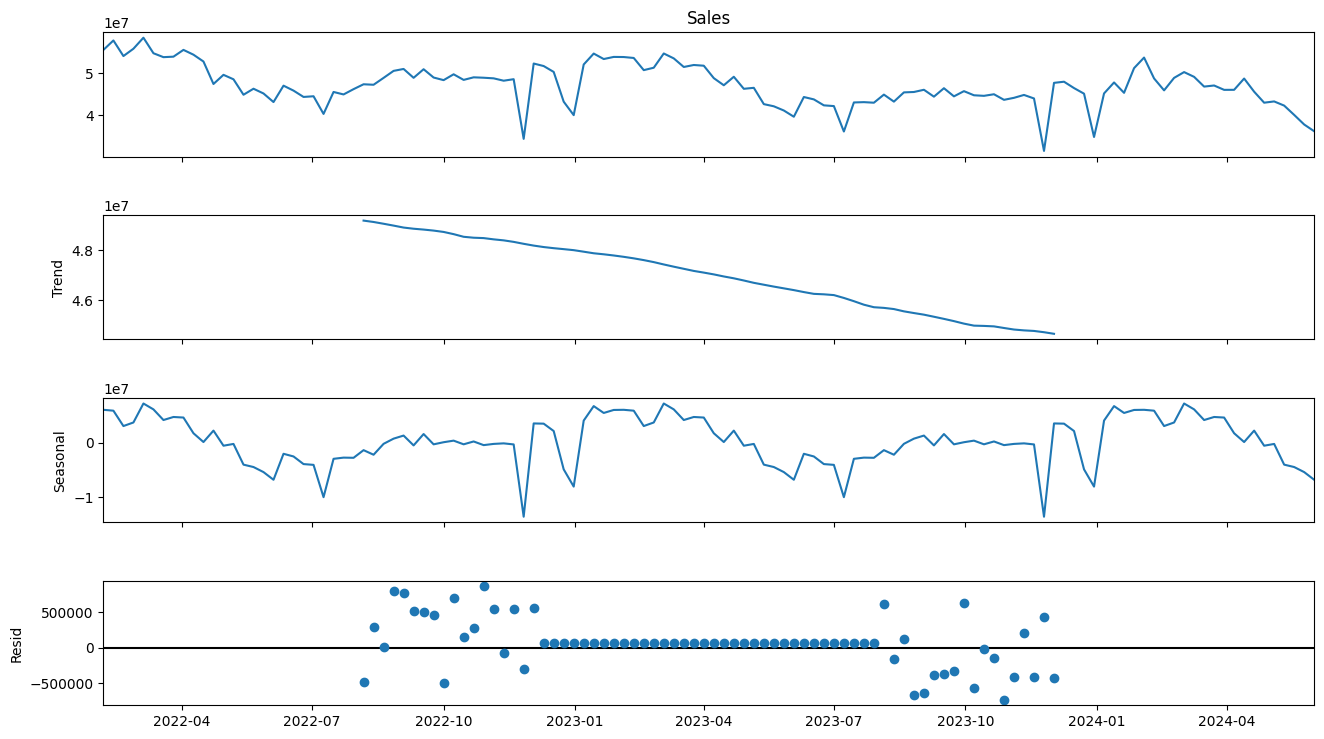

In [10]:
# Decompose sales time series
decomposition = seasonal_decompose(df.set_index('Week_Ending')['Sales'], model='additive', period=52)
fig = decomposition.plot()
fig.set_size_inches(15, 8)
plt.show()

In [11]:
# Holiday impact analysis
holiday_sales = df.groupby('Holiday Dummy')['Sales'].mean()
print(holiday_sales)

Holiday Dummy
0    4.740410e+07
1    3.301258e+07
Name: Sales, dtype: float64


## Modeling

In [12]:
# Load data
data = pd.read_excel("C:\\Users\\Channabasava\\Desktop\\Test\\MMX_Task.xlsx", sheet_name='Sheet1')

In [13]:
# Data cleaning - ensure numeric columns are properly typed
numeric_cols = ['Sales', 'Discount1', 'Discount2', 'Total SKU', 'Gasoline Price', 
               'Average Price', 'Email Clicks', 'Email Spends', 
               'Organic Search Impressions', 'Modular Video Impressions',
               'Modular Video Spends', 'Paid Social Impressions',
               'Paid Social Spends', 'Paid Search Impressions',
               'Paid Search Spends']

for col in numeric_cols:
    data[col] = pd.to_numeric(data[col], errors='coerce')

# Fill any NA values that resulted from conversion
data.fillna(0, inplace=True)

In [14]:
# Convert Week_Ending to datetime and extract time features
data['Week_Ending'] = pd.to_datetime(data['Week_Ending'])
data['week_of_year'] = data['Week_Ending'].dt.isocalendar().week
data['month'] = data['Week_Ending'].dt.month

In [15]:
data.columns

Index(['Department', 'Week_Ending', 'Year', 'MAT', 'Sales', 'Discount1',
       'Discount2', 'Holiday Dummy', 'Total SKU', 'Gasoline Price',
       'Average Price', 'Email Clicks', 'Email Spends',
       'Organic Search Impressions', 'Modular Video Impressions',
       'Modular Video Spends', 'Paid Social Impressions', 'Paid Social Spends',
       'Paid Search Impressions', 'Paid Search Spends', 'week_of_year',
       'month'],
      dtype='object')

In [16]:
# Create Fourier terms for seasonality
n_weeks = 52
time_period = np.arange(len(data))
data['fourier_sin1'] = np.sin(2 * np.pi * time_period / n_weeks)
data['fourier_cos1'] = np.cos(2 * np.pi * time_period / n_weeks)
data['fourier_sin2'] = np.sin(4 * np.pi * time_period / n_weeks)
data['fourier_cos2'] = np.cos(4 * np.pi * time_period / n_weeks)

In [17]:
data.head(3)

,Department,Week_Ending,Year,MAT,Sales,Discount1,Discount2,Holiday Dummy,Total SKU,Gasoline Price,...,Paid Social Impressions,Paid Social Spends,Paid Search Impressions,Paid Search Spends,week_of_year,month,fourier_sin1,fourier_cos1,fourier_sin2,fourier_cos2
0,Brand A,2022-02-05,FY_2022,MAT_2022,5.549708e+07,0.039253,0.015600,0,29882443.5,1070.8565,...,280464068.5,3.861346e+06,6779.5,671.943906,5,2,0.000000,1.000000,0.000000,1.000000
1,Brand A,2022-02-12,FY_2022,MAT_2022,5.773779e+07,0.037425,0.014623,0,29719511.5,1070.8565,...,235058652.5,3.236218e+06,5110.0,506.472949,6,2,0.120537,0.992709,0.239316,0.970942
2,Brand A,2022-02-19,FY_2022,MAT_2022,5.404445e+07,0.061313,0.010034,0,29353173.5,1070.8565,...,257480818.0,3.544920e+06,2842.0,281.682216,7,2,0.239316,0.970942,0.464723,0.885456


In [18]:
# Define variables
target = 'Sales'
marketing_vars = ['Email Clicks', 'Organic Search Impressions', 
                 'Modular Video Impressions', 'Paid Social Impressions', 
                 'Paid Search Impressions']
control_vars = ['Gasoline Price', 'Average Price', 'Discount1', 'Discount2', 
               'Holiday Dummy', 'Total SKU']
seasonality_vars = ['month', 'week_of_year', 'fourier_sin1', 'fourier_cos1',
                   'fourier_sin2', 'fourier_cos2']

In [19]:
# Log transform variables (adding small constant to avoid log(0))
data_log = data.copy()
for var in [target] + marketing_vars:
    data_log[var] = np.log(data[var] + 1)

In [20]:
data_log.head(4)

,Department,Week_Ending,Year,MAT,Sales,Discount1,Discount2,Holiday Dummy,Total SKU,Gasoline Price,...,Paid Social Impressions,Paid Social Spends,Paid Search Impressions,Paid Search Spends,week_of_year,month,fourier_sin1,fourier_cos1,fourier_sin2,fourier_cos2
0,Brand A,2022-02-05,FY_2022,MAT_2022,17.831841,0.039253,0.015600,0,29882443.5,1070.8565,...,19.451956,3.861346e+06,8.821806,671.943906,5,2,0.000000,1.000000,0.000000,1.000000
1,Brand A,2022-02-12,FY_2022,MAT_2022,17.871423,0.037425,0.014623,0,29719511.5,1070.8565,...,19.275346,3.236218e+06,8.539150,506.472949,6,2,0.120537,0.992709,0.239316,0.970942
2,Brand A,2022-02-19,FY_2022,MAT_2022,17.805317,0.061313,0.010034,0,29353173.5,1070.8565,...,19.366456,3.544920e+06,7.952615,281.682216,7,2,0.239316,0.970942,0.464723,0.885456
3,Brand A,2022-02-26,FY_2022,MAT_2022,17.836851,0.066293,0.023455,0,29324354.5,1070.8565,...,19.439138,3.812168e+06,8.016978,300.414777,8,2,0.354605,0.935016,0.663123,0.748511


In [21]:
# Standardize variables - convert to numpy array first to avoid dtype issues
scaler = StandardScaler()
scaled_features = scaler.fit_transform(data_log[marketing_vars + control_vars])
scaled_data = data_log.copy()
scaled_data[marketing_vars + control_vars] = scaled_features

In [22]:
# Adstock transformation function with numpy arrays
def adstock_transform(x, decay_rate=0.3):
    x = np.array(x)
    x_adstock = np.zeros_like(x)
    x_adstock[0] = x[0]
    for t in range(1, len(x)):
        x_adstock[t] = x[t] + decay_rate * x_adstock[t-1]
    return x_adstock

In [23]:
# Apply adstock to marketing variables
for var in marketing_vars:
    scaled_data[f'{var}_adstock'] = adstock_transform(scaled_data[var])

In [24]:
# Prepare final modeling variables
adstock_vars = [f'{var}_adstock' for var in marketing_vars]
all_vars = adstock_vars + control_vars + seasonality_vars

In [25]:
# Ensure no missing values in final dataset
model_data = scaled_data[all_vars + [target]].dropna()

In [26]:
# Fit linear regression model
X = sm.add_constant(model_data[all_vars])
y = model_data[target]

In [27]:
X.dtypes

const                                 float64
Email Clicks_adstock                  float64
Organic Search Impressions_adstock    float64
Modular Video Impressions_adstock     float64
Paid Social Impressions_adstock       float64
Paid Search Impressions_adstock       float64
Gasoline Price                        float64
Average Price                         float64
Discount1                             float64
Discount2                             float64
Holiday Dummy                         float64
Total SKU                             float64
month                                   int32
week_of_year                           UInt32
fourier_sin1                          float64
fourier_cos1                          float64
fourier_sin2                          float64
fourier_cos2                          float64
dtype: object

In [28]:
X["week_of_year"] = X["week_of_year"].astype(int)

In [29]:
X.dtypes

const                                 float64
Email Clicks_adstock                  float64
Organic Search Impressions_adstock    float64
Modular Video Impressions_adstock     float64
Paid Social Impressions_adstock       float64
Paid Search Impressions_adstock       float64
Gasoline Price                        float64
Average Price                         float64
Discount1                             float64
Discount2                             float64
Holiday Dummy                         float64
Total SKU                             float64
month                                   int32
week_of_year                            int64
fourier_sin1                          float64
fourier_cos1                          float64
fourier_sin2                          float64
fourier_cos2                          float64
dtype: object

In [30]:
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  Sales   R-squared:                       0.877
Model:                            OLS   Adj. R-squared:                  0.857
Method:                 Least Squares   F-statistic:                     43.58
Date:                Mon, 31 Mar 2025   Prob (F-statistic):           1.78e-39
Time:                        00:41:40   Log-Likelihood:                 227.24
No. Observations:                 122   AIC:                            -418.5
Df Residuals:                     104   BIC:                            -368.0
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
cons

1. OLS regression model explains 87.7% (R² = 0.877) of the variation in Sales, indicating a strong fit. The adjusted R² of 0.857 accounts for the number of predictors and confirms a robust model.


2. Significant Predictors (p < 0.05)

Organic Search Impressions: A 1-unit increase leads to a 0.0306 unit increase in Sales, meaning organic search plays a major role in driving revenue.

Paid Social Impressions: A 1-unit increase leads to a 0.0115 unit increase in Sales, suggesting that social media ads have a measurable impact on revenue.

Discount2: Has a positive impact on Sales, indicating that offering larger discounts can boost sales volume.

Holiday Dummy: Sales tend to decrease by 0.0404 units during holidays, meaning holiday periods negatively affect business.

Month Variable: Sales increase over time, showing a positive trend in monthly performance.

Week of Year: Sales decline slightly on a weekly basis, indicating seasonal fluctuations.

Fourier Terms (sin/cos): Capture seasonality effects in sales trends, indicating cyclical patterns in purchasing behavior.


3. Insignificant Predictors (p > 0.05)

Email Clicks: No significant impact on Sales, suggesting that email campaigns are not effectively driving revenue.

Modular Video Impressions: No strong evidence that modular videos significantly increase Sales.

Paid Search Impressions: Slightly negative impact but not statistically significant, meaning search ads may not be optimized effectively.

Average Price: Price changes do not show a strong direct effect on Sales.


4. Business Implications

Increase budget allocation to Paid Social and Organic Search, as they are the top contributors to Sales.

Reevaluate Email Marketing & Paid Search strategies, since they show little to no impact on Sales.

Use more targeted discounting strategies, as discounts (Discount2) significantly boost Sales.

Adjust marketing efforts during holidays, as they negatively impact Sales.

Consider seasonality effects when planning campaigns, as Fourier terms show cyclical sales trends.

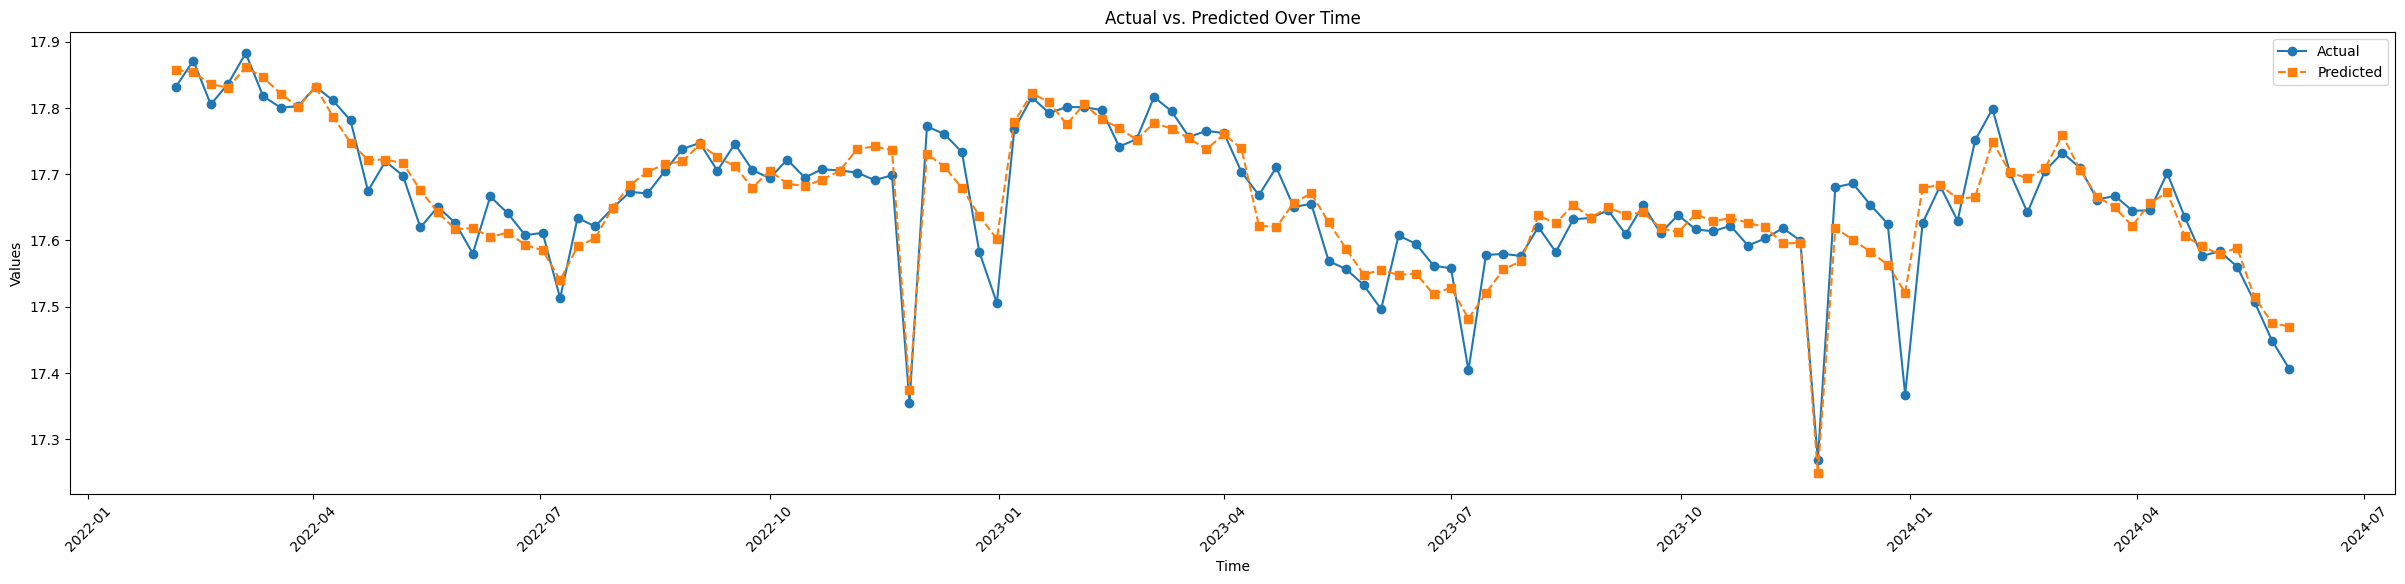

In [31]:
from sklearn.metrics import r2_score


time = data['Week_Ending']

# Predict values
y_pred = model.predict(sm.add_constant(X))

# Calculate residuals
residuals = y - y_pred

# R-squared value
r2 = r2_score(y, y_pred)

# Plot Actual vs. Predicted over Time
plt.figure(figsize=(30, 6))
plt.plot(time, y, label='Actual', marker='o', linestyle='-')
plt.plot(time, y_pred, label='Predicted', marker='s', linestyle='--')
plt.xlabel("Time")
plt.ylabel("Values")
plt.title("Actual vs. Predicted Over Time")
plt.legend()
plt.xticks(rotation=45)
plt.show()

In [33]:
X.to_csv("C:\\Users\\Channabasava\\Desktop\\Test\\X.csv")